<a target="_blank" href="https://colab.research.google.com/github/neurorishika/PyGORL/blob/main/analysis/dm_task_selection.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deepmind TurnerLab (Pillar IV) Task Selection

**Code Author:** *Rishika Mohanta*

In [1]:
# LIBRARY IMPORTS

# import libraries
import numpy as np                  # for linear algebra
import matplotlib.pyplot as plt     # for plotting
from tqdm import tqdm               # for progress bar

### Compare sampling methods for length of each trial blocks

Here we compare two methods to sample trials for each block:Uniform and truncated exponential distribution. We want to see if the two methods produce similar results in the distribution of observed observed hazard rates.

For the Uniform method we sample uniformly between `Min_Block_Length` and `Max_Block_Length`. For the truncated exponential distribution we sample randomly from three hazard rates. The distributions are truncated at `Min_Block_Length` and `Max_Block_Length`.

Further the samples are rounded to the nearest multiple of `Round_To`

In [2]:
# SAMPLE BLOCK LENGTHS FOR DM TASK SELECTION

N = 50000                   # Number of samples
Min_Block_Length = 20       # Minimum block length
Max_Block_Length = 150      # Maximum block length
Round_To = 1                # Round to nearest multiple of this number

# Generate random block lengths

## Uniform distribution
Block_Lengths_U = np.random.randint(Min_Block_Length, Max_Block_Length, N)

## Geometric distribution
Block_Lengths_E = np.array([])
hazard_rates = [0.035,0.02,0.01]
N_ = N//len(hazard_rates)
for i in range(len(hazard_rates)):
    while len(Block_Lengths_E) < N_*(i+1):
        Block_Lengths_E = np.append(Block_Lengths_E, np.random.geometric(hazard_rates[i], N_*(i+1)-len(Block_Lengths_E)))
        # filter out values outside of range
        Block_Lengths_E = Block_Lengths_E[Block_Lengths_E >= Min_Block_Length]
        Block_Lengths_E = Block_Lengths_E[Block_Lengths_E <= Max_Block_Length]

# Round to nearest multiple of Round_To
Block_Lengths_E = np.floor(Block_Lengths_E/Round_To)*Round_To
Block_Lengths_U = np.floor(Block_Lengths_U/Round_To)*Round_To

### Plot the sampled distibutions

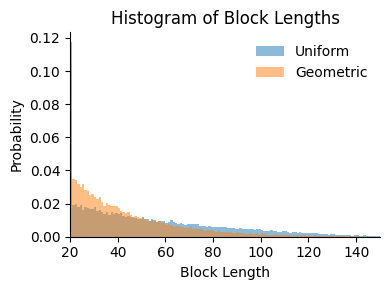

In [14]:
# Plot histogram of block lengths

plt.figure(figsize=(4,3), dpi=100)
plt.hist(Block_Lengths_U, 
         bins=np.arange(Min_Block_Length, Max_Block_Length+Round_To, Round_To), 
         alpha=0.5, label='Uniform', density=True)
plt.hist(Block_Lengths_E, 
         bins=np.arange(Min_Block_Length, Max_Block_Length+Round_To, Round_To), 
         alpha=0.5, label='Geometric', density=True)
plt.legend(loc='upper right', frameon=False)
plt.xlabel('Block Length')
plt.ylabel('Probability')
plt.title('Histogram of Block Lengths')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.xlim([Min_Block_Length, Max_Block_Length])
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 13095.66it/s]


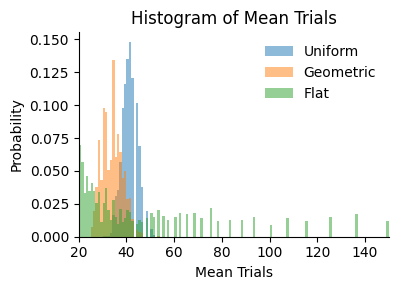

In [34]:
# Number of trials
N_trials = 1500

plt.figure(figsize=(4,3), dpi=100)
# generate experiments
for Block_Lengths in [Block_Lengths_U, Block_Lengths_E,]:
    Experiments = []
    current_marker = 0
    for i in range(1,N):
        if np.sum(Block_Lengths[current_marker:i]) >= N_trials:
            exps = Block_Lengths[current_marker:i]
            if sum(exps) > N_trials:
                exps[-1] = N_trials - sum(exps[:-1])
            Experiments.append(exps)
            current_marker = i

    # calculate mean trials of each experiment
    mean_trials = []
    for i in range(len(Experiments)):
        mean_trials.append(np.mean(Experiments[i]))

    # Plot histogram of hazard rates
    plt.hist(mean_trials, density=True, bins=np.arange(20,151,Round_To),
                alpha=0.5, label='Geometric' if Block_Lengths is Block_Lengths_E else 'Uniform')

Experiments = []
for n in tqdm(range(1000)):
    exp = []

    N_max = int(np.floor(N_trials/Min_Block_Length))
    N_min = int(np.ceil(N_trials/Max_Block_Length))
    sample_N = np.random.randint(N_min, N_max+1)

    # split N_trials into sample_N blocks by calculating split points at equal intervals
    split_points = np.linspace(0, N_trials, sample_N+1)
    split_points = np.round(split_points)
    block_lengths = np.diff(split_points)

    # 2*noise_limit + max(block_lengths) <= Max_Block_Length
    # => noise_limit <= (Max_Block_Length - max(block_lengths))/2
    # also, min(block_lengths)-2*noise_limit >= Min_Block_Length
    # => noise_limit <= (min(block_lengths)-Min_Block_Length)/2
    # Therefore, noise_limit <= min(Max_Block_Length - max(block_lengths)/2, (min(block_lengths)-Min_Block_Length)/2)

    noise_limit = np.min([(Max_Block_Length - np.max(block_lengths))/2, (np.min(block_lengths)-Min_Block_Length)/2])
    noise_limit = int(np.floor(noise_limit))
    if noise_limit > 0:
        # add noise to split points
        split_points[1:-1] = split_points[1:-1] + np.random.randint(-noise_limit, noise_limit, sample_N-1)
        block_lengths = np.diff(split_points)

    assert len(block_lengths) == sample_N, 'Incorrect number of blocks'
    assert np.all(block_lengths >= Min_Block_Length), 'Block lengths too small'
    assert np.all(block_lengths <= Max_Block_Length), 'Block lengths too large. {} > {}, N: {}'.format(np.max(block_lengths), Max_Block_Length, noise_limit)

    # add blocks to protocol
    for block_length in block_lengths:
        exp.append(block_length)

    Experiments.append(exp)

# calculate mean trials of each experiment
mean_trials = []
for i in range(len(Experiments)):
    mean_trials.append(np.mean(Experiments[i]))

# Plot histogram of hazard rates
plt.hist(mean_trials, density=True, bins=np.arange(20,151,Round_To),
            alpha=0.5, label='Flat')

plt.legend(loc='upper right', frameon=False)
plt.xlabel('Mean Trials')
plt.ylabel('Probability')
plt.title('Histogram of Mean Trials')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.xlim([20, 150])
plt.show()


100%|██████████| 1000/1000 [00:59<00:00, 16.68it/s]


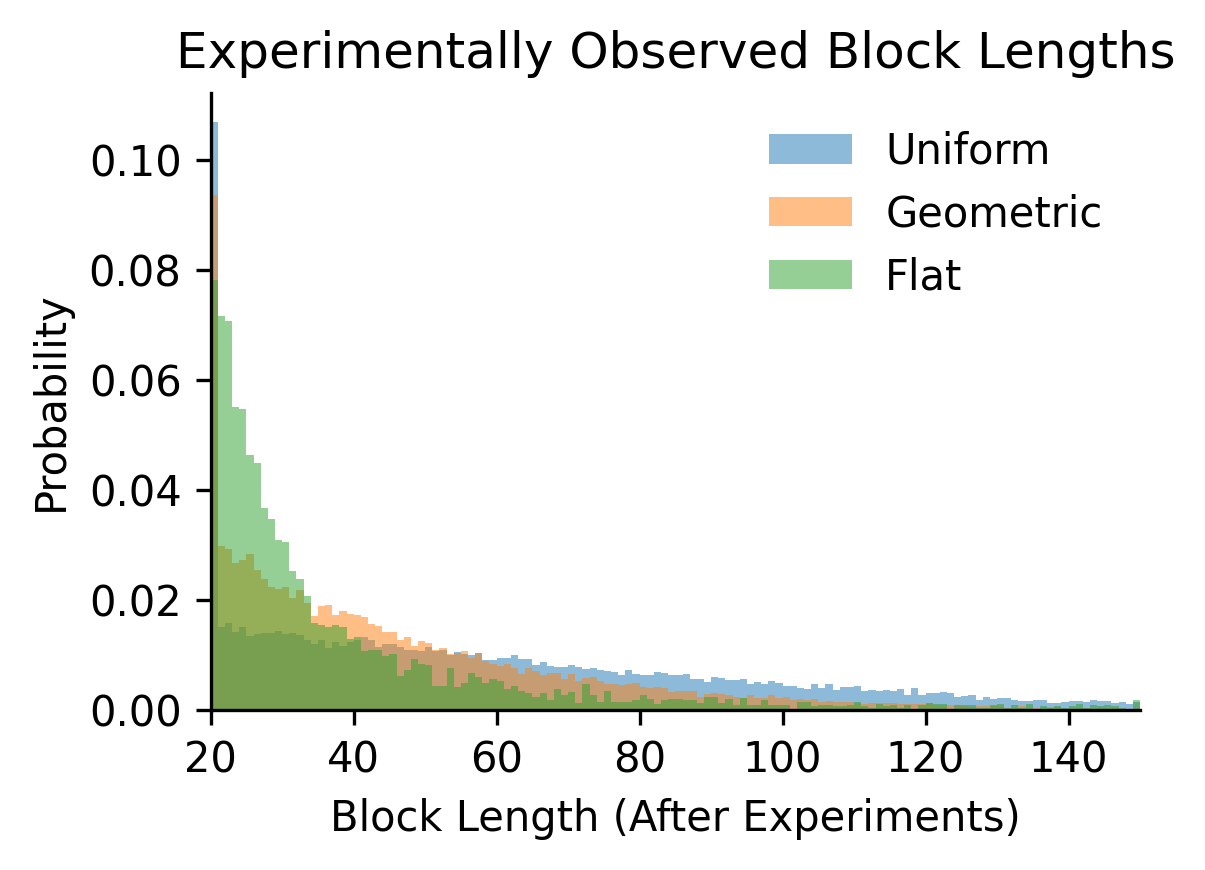

In [6]:
# Number of trials
N_trials = 170
plt.figure(figsize=(4,3), dpi=300)
# generate experiments
for Block_Lengths in [Block_Lengths_U, Block_Lengths_E]:
    Experiments = []
    current_marker = 0
    for i in range(1,N):
        if np.sum(Block_Lengths[current_marker:i]) >= N_trials:
            exps = Block_Lengths[current_marker:i]
            if sum(exps) > N_trials:
                exps[-1] = N_trials - sum(exps[:-1])
            Experiments.append(exps)
            current_marker = i

    # Plot histogram of block lengths
    plt.hist(np.concatenate(Experiments),
         bins=np.arange(Min_Block_Length, Max_Block_Length+Round_To, Round_To), 
         alpha=0.5, label='Uniform' if Block_Lengths is Block_Lengths_U else 'Geometric', density=True)
    
Experiments = []
for n in tqdm(range(1000)):
    exp = []
    min_mean_block_length = 20
    multinomial_N_max = int(np.floor(N_trials/min_mean_block_length))
    sample_N = np.random.randint(2, multinomial_N_max)
    while True:
            # split N_exp_trials into sample_N blocks
            split_points = np.random.choice(np.arange(1, N_trials), sample_N-1, replace=False)
            split_points = np.sort(split_points)
            split_points = np.concatenate([[0], split_points, [N_trials]])
            block_lengths = np.diff(split_points)
            # check if block lengths are within limits
            if np.all(block_lengths >= Min_Block_Length) and np.all(block_lengths <= Max_Block_Length):
                    break
    # verify that the number of blocks is correct
    assert len(block_lengths) == sample_N, 'Incorrect number of blocks'
    # add blocks to protocol
    for block_length in block_lengths:
            exp.append(block_length)
    Experiments.append(exp)

# Plot histogram of hazard rates
plt.hist(np.concatenate(Experiments),
            bins=np.arange(Min_Block_Length, Max_Block_Length+Round_To, Round_To),
            alpha=0.5, label='Flat', density=True)

plt.legend(loc='upper right', frameon=False)
plt.xlabel('Block Length (After Experiments)')
plt.ylabel('Probability')
plt.title('Experimentally Observed Block Lengths')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.xlim([20, 150])
plt.show()


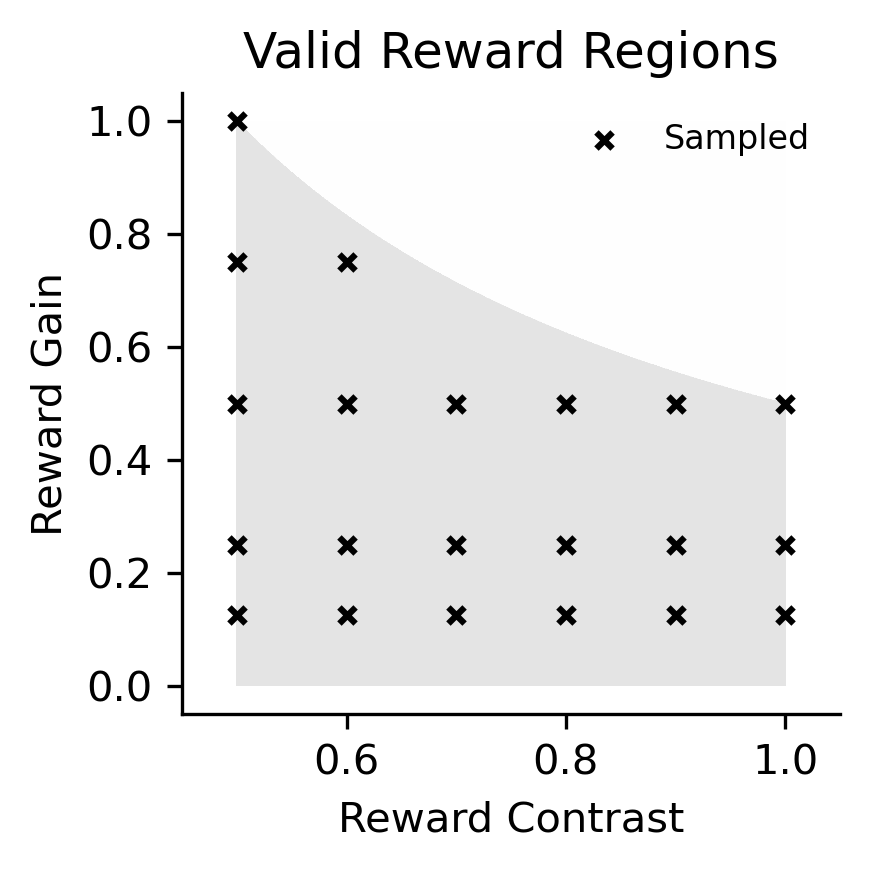

In [ ]:
reward_contrasts = np.linspace(0.5, 1, 1000)
reward_gains = np.linspace(0, 1, 1000)

sampled_gains = [0.125,0.25,0.5,0.75,1.0]
sampled_contrasts = [0.5,0.6,0.7,0.8,0.9,1.0]
# create grid
X, Y = np.meshgrid(reward_contrasts, reward_gains)
sampled_X, sampled_Y = np.meshgrid(sampled_contrasts, sampled_gains)

# calculate reward probabilities
Z = 2* X * Y
Z_ = 2 * Y * (1-X)
sampled_Z = 2* sampled_X * sampled_Y
sampled_Z_ = 2 * sampled_Y * (1-sampled_X)

# check where reward probabilities are valid
Z_valid = np.logical_and(Z >= 0, Z <= 1)
Z__valid = np.logical_and(Z_ >= 0, Z_ <= 1)
sampled_Z_valid = np.logical_and(sampled_Z >= 0, sampled_Z <= 1)
sampled_Z__valid = np.logical_and(sampled_Z_ >= 0, sampled_Z_ <= 1)

# check where both reward probabilities are valid
Z_both_valid = np.logical_and(Z_valid, Z__valid)
sampled_Z_both_valid = np.logical_and(sampled_Z_valid, sampled_Z__valid)

# get valid sampled reward contrasts and gains
valid_sampled_contrasts = sampled_X[sampled_Z_both_valid]
valid_sampled_gains = sampled_Y[sampled_Z_both_valid]

# plot the valid reward regions
plt.figure(figsize=(3,3), dpi=300)
plt.contourf(X, Y, Z_both_valid, cmap='Greys', vmin=0, vmax=5)
# plot the sampled reward contrasts and gains
plt.scatter(valid_sampled_contrasts, valid_sampled_gains, c='k', s=15, marker='x', label='Sampled')
plt.xlabel('Reward Contrast')
plt.ylabel('Reward Gain')
plt.title('Valid Reward Regions')
plt.legend(loc='upper right', frameon=False, fontsize=8)
plt.xlim([0.45, 1.05])
plt.ylim([-0.05, 1.05])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
# protocol generation code
import numpy as np

def generate_protocol(
        N_naive_trials=10,
        N_exp_trials=190,
        block_distribution='geometric',
        block_limits=[20, 150],
        hazard_rates=[0.035,0.02,0.01],
        max_hazard_rate=None,
        reward_contrasts=[0.5,0.6,0.7,0.8,0.9,1.0],
        reward_gains=[0.125,0.25,0.5,0.75,1.0],
        alternating=True,
        expectation_sampling=False,
        seed=None
):
        """
        Generate a protocol for a 2AFC task with a variable number of trials per block.

        Parameters
        ----------
        N_naive_trials : int
                Number of naive trials to include in the beginning of the protocol.
        N_exp_trials : int
                Number of experimental trials to include in the protocol.
        block_distribution : str
                Distribution to use for block lengths. Must be one of 'geometric', 'uniform', or 'flat'.
        block_limits : list
                Limits for block lengths. Must be in the form [min, max].
        hazard_rates : list
                Hazard rates to sample from for geometric block distribution. Must be in the form [hazard_rate_1, hazard_rate_2, ...].
        max_hazard_rate : float
                Maximum hazard rate to sample from for flat block distribution. Must be a float between 0 and 1/min(block_limits).
        reward_contrasts : list
                Reward contrasts to sample from. Must be in the form [contrast_1, contrast_2, ...].
        reward_gains : list
                Reward gains to sample from. Must be in the form [gain_1, gain_2, ...].
        alternating : bool
                Whether to alternate the higher reward between two blocks.
        expectation_sampling : bool
                Whether to use the expectation of the reward distribution to ensure exactly the expected number of trials are rewarded in each block.
        seed : int
                Seed for random number generator.
        """

        # Validate inputs
        
        assert block_distribution in ['geometric', 'uniform', 'flat'], 'block_distribution must be one of "geometric", "uniform", or "flat"'
        assert len(block_limits) == 2, 'block_limits must be a list of length 2'
        assert block_limits[0] < block_limits[1], 'block_limits must be in the form [min, max]'

        if block_distribution == 'geometric':
                assert hazard_rates is not None, 'hazard_rates must be specified for geometric block distribution'
                assert np.all(np.array(hazard_rates) >= 0), 'hazard_rates must be greater than or equal to 0'
                assert np.all(np.array(hazard_rates) <= 1), 'hazard_rates must be less than or equal to 1'
        else:
                hazard_rates = None

        if block_distribution == 'flat':
                assert max_hazard_rate is not None, 'max_hazard_rate must be specified for flat block distribution'
                assert max_hazard_rate >= 0, 'max_hazard_rate must be greater than or equal to 0'
                assert max_hazard_rate <= 1/np.min(block_limits), 'max_hazard_rate must be less than or equal to 1/min(block_limits)'
        else:
                max_hazard_rate = None
                
        assert np.all(np.array(reward_contrasts) >= 0.5), 'reward_contrasts must be greater than or equal to 0.5'
        assert np.all(np.array(reward_contrasts) <= 1), 'reward_contrasts must be less than or equal to 1'
        assert np.all(np.array(reward_gains) > 0), 'reward_gains must be greater than 0'
        assert np.all(np.array(reward_gains) <= 1), 'reward_gains must be less than or equal to 1'

        # set seed
        if seed is not None:
                np.random.seed(seed)
        else:
                np.random.seed()
        
        # generate block lengths
        exp = []
        if block_distribution == 'flat':
                min_mean_block_length = 1/max_hazard_rate
                multinomial_N_max = int(np.floor(N_exp_trials/min_mean_block_length))
                sample_N = np.random.randint(2, multinomial_N_max)
                while True:
                        # split N_exp_trials into sample_N blocks
                        split_points = np.random.choice(np.arange(1, N_exp_trials), sample_N-1, replace=False)
                        split_points = np.sort(split_points)
                        split_points = np.concatenate([[0], split_points, [N_exp_trials]])
                        block_lengths = np.diff(split_points)
                        # check if block lengths are within limits
                        if np.all(block_lengths >= block_limits[0]) and np.all(block_lengths <= block_limits[1]):
                                break
                # verify that the number of blocks is correct
                assert len(block_lengths) == sample_N, 'Incorrect number of blocks'
                # add blocks to protocol
                for block_length in block_lengths:
                        exp.append(block_length)
        else:
                if block_distribution == 'geometric':
                        hazard_rate = np.random.choice(hazard_rates)

                while True:
                        # generate block lengths
                        if block_distribution == 'geometric':
                                block_length = np.random.geometric(hazard_rate)
                        elif block_distribution == 'uniform':
                                block_length = np.random.randint(block_limits[0], block_limits[1]+1)
                        # check if block length is within limits
                        if block_length >= block_limits[0] and block_length <= block_limits[1]:
                                exp.append(block_length)
                        # check if total number of trials is correct
                        if np.sum(exp) >= N_exp_trials:
                                if np.sum(exp) > N_exp_trials:
                                        exp[-1] = exp[-1] - (np.sum(exp) - N_exp_trials)
                                break
        assert np.sum(exp) == N_exp_trials, 'Incorrect number of experimental trials'
        # print('Experimental block lengths: {}'.format(exp))

        # generate probabilities
        o1 = np.zeros(N_naive_trials+N_exp_trials)
        o2 = np.zeros(N_naive_trials+N_exp_trials)

        i = N_naive_trials
        max_state = 0
        for block_length in exp:
                # generate reward probabilities
                while True:
                        sampled_reward_gain = np.random.choice(reward_gains)
                        sampled_reward_contrast = np.random.choice(reward_contrasts)

                        p1 = 2 * sampled_reward_gain * sampled_reward_contrast
                        p2 = 2 * sampled_reward_gain * (1 - sampled_reward_contrast)

                        if (p1 >= 0) and (p1 <= 1) and (p2 >= 0) and (p2 <= 1):
                                break
                
                # generate blocks
                if alternating:
                        if max_state == 0:
                                o1[i:i+block_length] = p1
                                o2[i:i+block_length] = p2
                                max_state = 1
                        else:
                                o1[i:i+block_length] = p2
                                o2[i:i+block_length] = p1
                                max_state = 0
                else:
                        if np.random.rand() < 0.5:
                                o1[i:i+block_length] = p1
                                o2[i:i+block_length] = p2
                        else:
                                o1[i:i+block_length] = p2
                                o2[i:i+block_length] = p1

                if expectation_sampling:
                        ep1 = np.floor(p1*block_length)
                        ep2 = np.floor(p2*block_length)
                        ep1_ = [1]*int(ep1) + [0]*int(block_length-ep1)
                        ep2_ = [1]*int(ep2) + [0]*int(block_length-ep2)
                        np.random.shuffle(ep1_)
                        np.random.shuffle(ep2_)

                        if alternating:
                                if max_state == 0:
                                        o1[i:i+block_length] = ep1_
                                        o2[i:i+block_length] = ep2_
                                        max_state = 1
                                else:
                                        o1[i:i+block_length] = ep2_
                                        o2[i:i+block_length] = ep1_
                                        max_state = 0
                        else:
                                if np.random.rand() < 0.5:
                                        o1[i:i+block_length] = ep1_
                                        o2[i:i+block_length] = ep2_
                                else:
                                        o1[i:i+block_length] = ep2_
                                        o2[i:i+block_length] = ep1_
                i += block_length
        
        return o1, o2

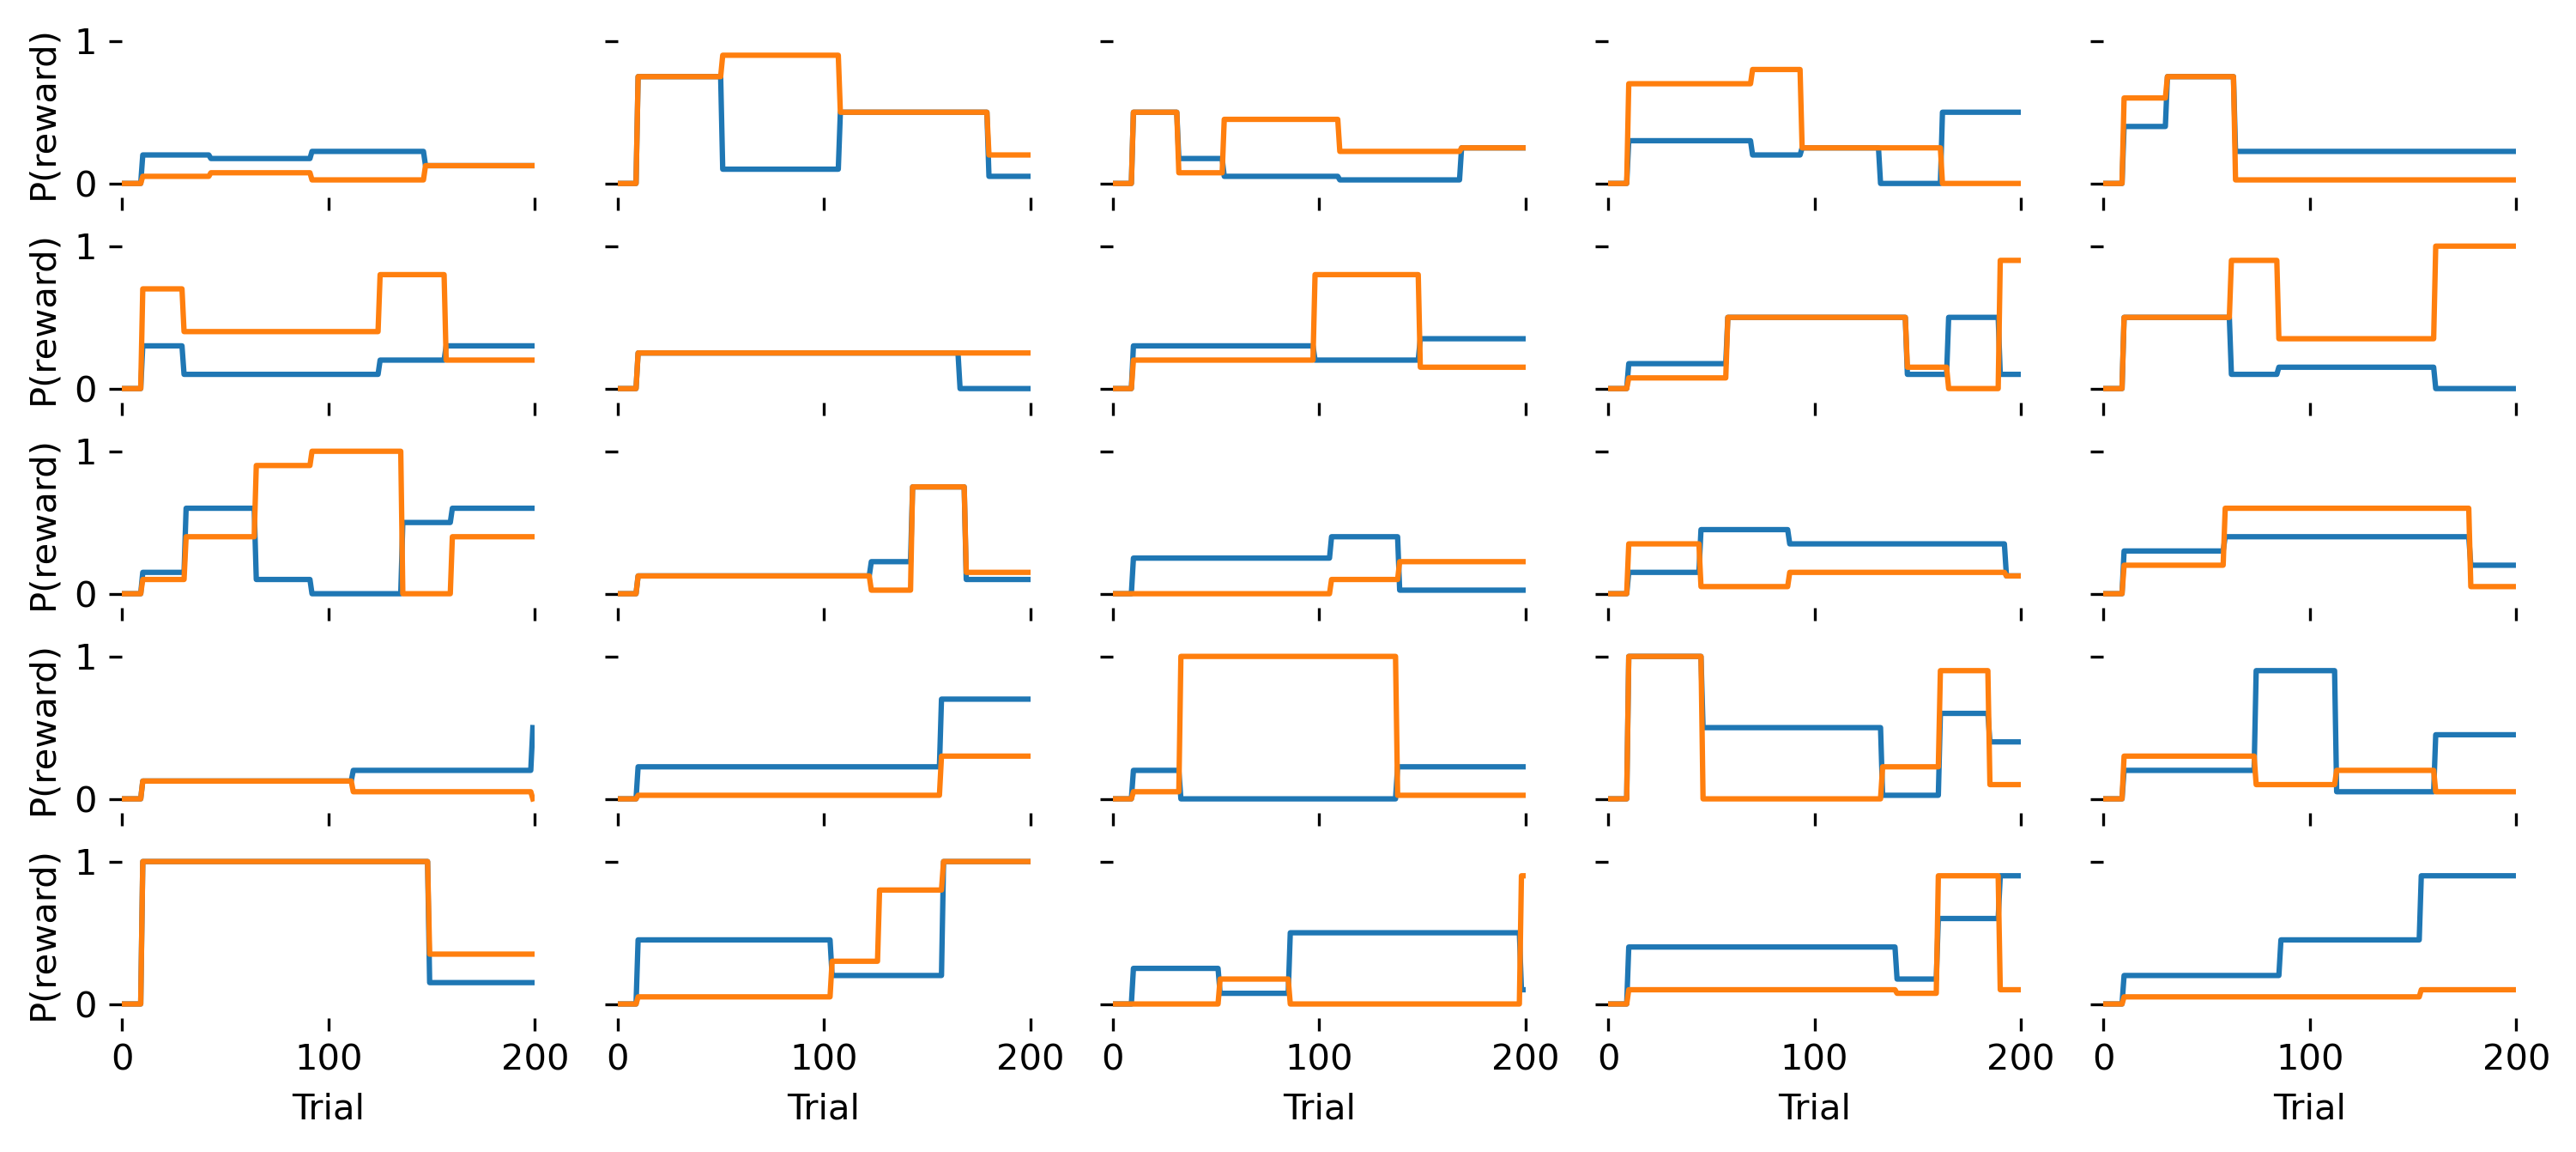

In [ ]:
fig,ax = plt.subplots(5,5,figsize=(12,5),sharex=True,sharey=True, dpi=300)
for i in range(25):
        o1,o2 = generate_protocol(alternating=False, expectation_sampling=False)
        ax[i//5,i%5].plot(np.arange(len(o1)), o1, '-')
        ax[i//5,i%5].plot(np.arange(len(o2)), o2, '-')
        if i//5 == 4:
            ax[i//5,i%5].set_xlabel('Trial')
        if i%5 == 0:
            ax[i//5,i%5].set_ylabel('P(reward)')
        ax[i//5,i%5].set_xlim(0,len(o1))
        ax[i//5,i%5].set_ylim(-0.1,1.1)
        # remove spines
        ax[i//5,i%5].spines['top'].set_visible(False)
        ax[i//5,i%5].spines['right'].set_visible(False)
        ax[i//5,i%5].spines['bottom'].set_visible(False)
        ax[i//5,i%5].spines['left'].set_visible(False)
plt.show()

In [ ]:
# protocol generation code
import numpy as np

def generate_protocol(
        N_naive_trials=10,
        N_exp_trials=190,
        block_distribution='geometric',
        block_limits=[20, 150],
        hazard_rates=[0.035,0.02,0.01],
        reward_contrasts=[0.5,0.6,0.7,0.8,0.9,1.0],
        reward_gains=[0.125,0.25,0.5,0.75,1.0],
        alternating=True,
        expectation_sampling=False,
        seed=None
):
        # set seed
        np.random.seed(seed)
        
        # generate block lengths
        exp = []
        hazard_rate = np.random.choice(hazard_rates) if block_distribution == 'geometric' else None

        while True:
            # generate block lengths
            block_length = np.random.geometric(hazard_rate) if block_distribution == 'geometric' else np.random.randint(block_limits[0], block_limits[1]+1)
            # check if block length is within limits
            if block_length >= block_limits[0] and block_length <= block_limits[1]:
                exp.append(block_length)
            # check if total number of trials is correct
            if np.sum(exp) >= N_exp_trials:
                exp[-1] = exp[-1] - (np.sum(exp) - N_exp_trials)
                break

        # generate probabilities
        o1, o2 = np.zeros(N_naive_trials + N_exp_trials), np.zeros(N_naive_trials + N_exp_trials)
        i = N_naive_trials
        max_state = 0

        for block_length in exp:
            # generate reward probabilities
            while True:
                sampled_reward_gain, sampled_reward_contrast = np.random.choice(reward_gains), np.random.choice(reward_contrasts)
                p1, p2 = 2 * sampled_reward_gain * sampled_reward_contrast, 2 * sampled_reward_gain * (1 - sampled_reward_contrast)
                if (p1 >= 0) and (p1 <= 1) and (p2 >= 0) and (p2 <= 1):
                    break
            if expectation_sampling:
                ep1, ep2 = int(p1*block_length), int(p2*block_length)
                ep1_, ep2_ = [1]*ep1 + [0]*(block_length-ep1), [1]*ep2 + [0]*(block_length-ep2)
                np.random.shuffle(ep1_)
                np.random.shuffle(ep2_)
                condition = (max_state == 0) if alternating else (np.random.rand() < 0.5)
                o1[i:i+block_length], o2[i:i+block_length] = ep1_ if condition else ep2_, ep2_ if condition else ep1_
                max_state = 1 - max_state
            else:
                condition = (max_state ==0) if alternating else (np.random.rand() < 0.5)
                o1[i:i+block_length], o2[i:i+block_length] = p1 if condition else p2, p2 if condition else p1
                max_state = 1 - max_state
            i += block_length
        return o1, o2